In [1]:
import os
import cv2
import glob
import json
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
#from progressbar import * #进度条
from tqdm import tqdm #进度条
from torchnet import meter
from natsort import natsorted
import matplotlib.pyplot as plt
import torch.nn.functional as F #torch是关于运算的包
from collections import defaultdict
from torch.autograd import Variable
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from torch.utils.data import Dataset
from torchvision import transforms as T
from torchvision import datasets,transforms, models #torchvision则是打包了一些数据集
#from sklearn.cross_validation import train_test_split
os.environ['CUDA_VISIBLE_DEVICES']='2,3'

### 数据预处理
#### 主要对图片数量小于10的图片扩充包括数据扩充

In [2]:
train_csv = pd.read_csv("data/train.csv")
temp_df = train_csv.groupby('Id').count()
#temp_df_subset = temp_df[temp_df.Image == 1]
temp_df_subset = temp_df[temp_df.Image <=10]
#print(temp_df_subset.shape)
#print(temp_df_subset)
temp_df_subset.to_csv('data/less10.csv')
less10 = pd.read_csv('data/less10.csv')
#print(less10.iloc[:, 0].values)
less10_class = less10.iloc[:, 0].values
print(less10_class)

['w_0003639' 'w_0003c59' 'w_0027efa' ... 'w_ffa6d42' 'w_ffcf5fe'
 'w_ffe8693']


In [3]:
def augmentDataSet(data_path, floder_list, seq):
    for floder in tqdm(floder_list):
        img_path = glob.glob(data_path + '/'+floder + '/*')
        
        if len(img_path) > 8:
            n = 2
        elif len(img_path) > 5:
            n = 3
        elif len(img_path) > 3:
            n = 5
        elif len(img_path) > 1:
            n = 9
        else:
            n = 10
            
        imglist = []
        for path in img_path:
            img = cv2.imread(path)
            imglist.append(img)
        for i in range(n):
            img_aug = seq.augment_images(imglist)
            for idx, img_ in enumerate(img_aug):
                cv2.imwrite(data_path + '/'+floder+'/aug_'+str(i + idx)+'.jpg', img_)

In [4]:
seq = iaa.Sequential([
    iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
    iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
    #iaa.Flipud(0.5), #上下翻转
    #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
    iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
    iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
],random_order=True)#每个batch中的Augmenters顺序不一样

data_path = 'data/train_aug_10'
augmentDataSet(data_path, less10_class, seq)

  0%|          | 3/4777 [00:03<1:31:34,  1.15s/it]


KeyboardInterrupt: 

#### 生成文件标签list

In [5]:
def generateFileList(data_path):
    file_class_list = []
    #file_class_dict = {}
    file_list = []
    for label in os.listdir(data_path):
        floder = data_path + '/' + label
        files = glob.glob(floder + '/*')
        #file_label = []
        for img_path in files:
            #file_label.append([img_path, label])
            #file_class_dict[str(img_path)] = label
            file_list.append(img_path)
            file_class_list.append([img_path, label])
    return file_list, file_class_list

In [6]:
file_list, file_class_list = generateFileList('data/net_classes')
#print(file_class_dict['data/train_aug_10/w_1efbb8e/b24ca77e2.jpg'])
print(len(file_class_list))
print(file_class_list[:10])
#print(file_class_dict[0])
print(len(file_list))

1325
[['data/net_classes/w_60ce6fc/adceba36f.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/2c2ae6eee.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/848acc823.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/a3e33a804.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/2e5cf6ca3.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/d2ab37982.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/6eff46d98.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/df6a26675.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/0ca116d49.jpg', 'w_60ce6fc'], ['data/net_classes/w_60ce6fc/be640ba7c.jpg', 'w_60ce6fc']]
1325


In [7]:
### 划分验证集 ###
#打乱顺序
num_example=len(file_class_list)
np.random.shuffle(file_class_list)

VALIDATION_SIZE = int(0.8*num_example)  #验证集大小
train_list, val_list = file_class_list[:VALIDATION_SIZE], file_class_list[VALIDATION_SIZE:]
print(len(train_list), len(val_list))

#转化为字典形式
file_id_mapping_train = {}
for item_ in train_list:
    k, v = item_[0], item_[1]
    file_id_mapping_train[k] = v
file_id_mapping_val = {}
for item_ in val_list:
    k, v = item_[0], item_[1]
    file_id_mapping_val[k] = v
#file_id_mapping_train = {k: v for k, v in zip(train_list[], train.Id.values)}
#file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}
print(len(file_id_mapping_val))
print(file_id_mapping_train['data/train_aug_10/w_593949b/aug_0.jpg'])

1060 265
265


KeyError: 'data/train_aug_10/w_593949b/aug_0.jpg'

In [11]:
class TrainAndValData(Dataset):
    def __init__(self, file_class_dict, train=True, img_size=224, other_class = "new_whale"):
        self.train = train
        self.file_class_mapping = file_class_dict
        self.class_to_list_files = defaultdict(list)
        self.list_other_class = []
        self.list_all_files = list(file_class_dict.keys())
        self.range_all_files = list(range(len(self.list_all_files)))
        for file, class_ in file_class_dict.items():
            if class_ == other_class:
                self.list_other_class.append(file)
            else:
                self.class_to_list_files[class_].append(file)   
                
        self.list_classes = list(set(self.file_class_mapping.values()))
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight/np.sum(self.class_weight)
        
        normalize = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
        if self.train == True:
            self.transforms = T.Compose([
                transforms.Grayscale(3),
                transforms.Resize((img_size, img_size)),
                T.RandomHorizontalFlip(),
                transforms.ToTensor(),
                #normalize
            ])
        else:
            self.transforms = T.Compose([
                transforms.Grayscale(3),
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                #normalize
            ]) 
    def __getitem__(self, index):
        #index 暂时无用
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_path_1, positive_path_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]],\
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]
        
        #positive_example_1 = self.imgs[index].keys
        
        negative_path = None
        while negative_path is None or self.file_class_mapping[negative_path] == \
                self.file_class_mapping[positive_path_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_path = self.list_all_files[negative_example_idx]
        
        positive_example_1 = Image.open(positive_path_1)
        positive_example_1 = self.transforms(positive_example_1)
        negative_example = Image.open(negative_path)
        negative_example = self.transforms(negative_example)
        positive_example_2 = Image.open(positive_path_2)
        positive_example_2 = self.transforms(positive_example_2)
        
        return positive_example_1, negative_example, positive_example_2        
    def __len__(self):
        return len(self.file_class_mapping)

In [12]:
train_dataset = TrainAndValData(file_id_mapping_train, train=True)
val_dataset = TrainAndValData(file_id_mapping_val, train=False)

train len is 1060
(3, 224, 224)


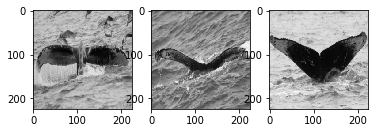

(3, 224, 224)


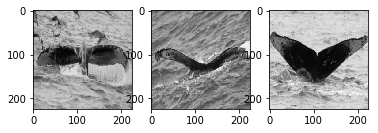

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f200a42c080>>
Traceback (most recent call last):
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/lhw/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/lhw/anaconda3/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
 

In [13]:
print('train len is %d' % len(train_dataset))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 1, shuffle=True, num_workers=4)
for i, (data1, data2, data3) in enumerate(train_dataloader):
    if i < 2:
        img1 = data1[0].numpy()
        print(img1.shape)
        img2 = data2[0].numpy()
        img3 = data3[0].numpy()
        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(img1,(1,2,0)))
        plt.subplot(1, 3, 2)
        plt.imshow(np.transpose(img2,(1,2,0)))
        plt.subplot(1, 3, 3)
        plt.imshow(np.transpose(img3,(1,2,0)))
        plt.show()
    else:
        break

### 设计网络

#### 构造损失函数

In [14]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
input1 = Variable(torch.randn(224, 224))
input2 = Variable(torch.randn(224, 224))
input3 = Variable(torch.randn(224, 224))
output = triplet_loss(input1, input2, input3)
print(output)

tensor(1.0444)


#### 网络

In [11]:
resnet50 = models.resnet50(pretrained=True)
#print(resnet50)

In [15]:
class triplet_model(nn.Module):
    def __init__(self, base_model='resnet50'):
        super(triplet_model, self).__init__()
        self.embedding_model = models.resnet50(pretrained=True)
        self.fc_features = self.embedding_model.fc.in_features
        self.embedding_model.fc = nn.Sequential(
            nn.Linear(self.fc_features, 64),
            nn.Dropout(p=0.5)
        )
    def foward_once(self, x):
        out = self.embedding_model(x)
        return out
    def forward(self, input1, input2, input3):
        out1 = self.foward_once(input1)
        out2 = self.foward_once(input2)
        out3 = self.foward_once(input3)
        return out1, out2, out3

In [16]:
model = triplet_model()
#print(model)
input1 = Variable(torch.randn(1, 3, 224, 224))
input2 = Variable(torch.randn(1, 3, 224, 224))
input3 = Variable(torch.randn(1, 3, 224, 224))
output1, output2, output3 = model(input1, input2, input3)
print(output1, output2, output3)

tensor([[ 0.0000, -0.1013, -0.3244,  0.0000,  0.0000,  0.0862, -0.1125,  0.1660,
         -0.3117, -0.0000, -0.8380,  0.0000,  0.6869,  0.1973, -0.0000, -0.0000,
          0.0000, -0.0754,  0.0000, -0.3852, -0.0000,  0.5244, -0.0000, -0.0000,
          0.0000, -0.4731, -0.6017, -0.1486, -0.3063, -0.8889, -0.3287,  0.2286,
         -0.0000, -0.3617, -0.0000,  0.3232, -0.9787, -0.0000, -0.3575, -0.0000,
         -0.0000, -0.0000, -0.0000,  0.0000,  1.0495, -0.4750,  0.1421, -0.0876,
         -0.0000, -0.0000,  0.6732, -0.4460, -0.8406, -0.6077,  0.1363, -0.1598,
         -0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000, -0.2760]],
       grad_fn=<DropoutBackward>) tensor([[ 0.8232, -0.0000, -0.0000,  0.1438,  0.0000,  0.0000, -0.1189,  0.1707,
         -0.3915, -0.0677, -0.8069,  0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          0.4202, -0.0000,  0.0875, -0.3683, -0.0000,  0.0000, -0.7722, -0.0000,
          0.0538, -0.0000, -0.5993, -0.1623, -0.3126, -0.0000, -0.3157,  

### 训练

In [17]:
#训练参数
batch_size = 32
#lr = 0.001
lr_decay = 0.995
weight_decay = 1e-4
epochs = 300
model_path = 'model/triplet_loss.ckpt'

In [21]:
def train(model_path):
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    net = triplet_model()
    ##多GPU
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net, device_ids=[0,1])
    if os.path.exists(model_path):
        net = torch.load(model_path)
    net = net.cuda()
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=weight_decay)
    #保存模型判断条件
    min_val_loss = 10000
    pre_epoch = 0
    max_interval_epoch = 20
    pre_train_loss = 100000

    print("Start Training...")
    for epoch in range(epochs):
        #训练集
        train_loss = 0
        train_count = 0
        net.train()
        train_loss = 0
        for i, data in enumerate(train_dataloader):
            img1, img2, img3 = data
            img1, img2, img3 = img1.cuda(), img2.cuda(),img3.cuda()
            optimizer.zero_grad()
            output1, output2, output3 = net(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            loss.backward()
            optimizer.step()
            #更新指标
            train_count += img1.size(0)
            train_loss += loss.item()
        train_loss /= train_count

        #验证集
        val_loss = 0
        val_count = 0
        net.eval()
        for i, data in enumerate(val_dataloader):
            img1, img2, img3 = data
            img1, img2, img3 = img1.cuda(), img2.cuda(),img3.cuda()
            optimizer.zero_grad()
            output1, output2, output3 = net(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            #更新指标
            val_count += img1.size(0)
            val_loss += loss.item()
        val_loss /= val_count
        # print the loss and accuracy
        print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), end=' ')
        print('the epoch %d, the train loss is %f, the val loss is %f' % (epoch, train_loss, val_loss))

        #保存模型
        if min_val_loss > val_loss:
            min_val_loss = val_loss
            pre_epoch = epoch
            torch.save(net, model_path)#保存整个神经网络的的结构信息和模型参数信息，save的对象是网络net
        if epoch - pre_epoch > max_interval_epoch:
            print('early stop')
            break

        #如果损失不载下降，则降低学习率
        if train_loss > pre_train_loss:
            lr = lr*lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        pre_train_loss = train_loss
    print("Done Training!")

In [22]:
train(model_path)

Start Training...
2018-12-15 23:29:26the epoch 0, the train loss is 0.034527, the val loss is 0.037937


/home/lhw/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type triplet_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


2018-12-15 23:30:09the epoch 1, the train loss is 0.030496, the val loss is 0.041559
2018-12-15 23:30:52the epoch 2, the train loss is 0.026417, the val loss is 0.041994
2018-12-15 23:31:35the epoch 3, the train loss is 0.031098, the val loss is 0.040700
2018-12-15 23:32:17the epoch 4, the train loss is 0.032527, the val loss is 0.165234
2018-12-15 23:33:00the epoch 5, the train loss is 0.034257, the val loss is 0.035560
2018-12-15 23:33:43the epoch 6, the train loss is 0.030386, the val loss is 0.036574
2018-12-15 23:34:26the epoch 7, the train loss is 0.032240, the val loss is 0.042996
2018-12-15 23:35:09the epoch 8, the train loss is 0.030149, the val loss is 0.099992
2018-12-15 23:35:51the epoch 9, the train loss is 0.033153, the val loss is 0.051002
2018-12-15 23:36:34the epoch 10, the train loss is 0.031712, the val loss is 0.034846
2018-12-15 23:37:17the epoch 11, the train loss is 0.029804, the val loss is 0.033853
2018-12-15 23:38:00the epoch 12, the train loss is 0.026268, th